# Random forests ( and OneR )
**Titanic kaggle competition**


### Setting up the environment and downloading the data

In [1]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
  colab_flag = True
else:
  colab_flag = False

if colab_flag == True:
   print("Running in Colab...")
   #Install Kaggle API
   ! pip install -q kaggle
   #Install Huggingface Datasets lib
   ! pip install -q datasets
   #Install Huggingface transformers & the sentencepiece
   ! pip install -q transformers[sentencepiece,torch]
   print("...Installed required dependencies")
else:
   print("Assuming running in local environment...")

Assuming running in local environment...


In [2]:
if colab_flag == True:
  import json
  from google.colab import drive
  drive.mount('/content/drive/')

  # Set the file path
  file_path = '/content/drive/MyDrive/dtu/fastAI/04_NLP/kaggle_api.json'

  # Check if the file exists
  if os.path.exists(file_path):
      # Load the JSON file
      with open(file_path) as f:
          creds = json.load(f)
      print('Sucesfully set kaggle credentials')
  else:
      # Handle the case when the file does not exist
      creds = None  # or any other appropriate action you want to take
      print('Error: File not found, Credentials NOT set')
else:
    import json
    file_path = "../secrets/kaggle_api.json"
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the JSON file
        with open(file_path) as f:
            creds = json.load(f)
        print('Sucesfully set kaggle credentials')
    else:
        # Handle the case when the file does not exist
        creds = None  # or any other appropriate action you want to take
        print('Error: File not found, Credentials NOT set')

Sucesfully set kaggle credentials


In [3]:
#using `pathlib.Path to work with paths in Python`
from pathlib import Path
#Set path for the titanic dataset
path = Path('titanic')

if path.exists():
  print('Data folder exists')
else:
  print('Data not detected, starting download')
  #Setup of kaggle credentials to use the API for downloading dataset
  cred_path = Path('~/.kaggle/kaggle.json').expanduser()
  if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(json.dumps(creds))
    #If not Json
    #cred_path.write_text(creds)
    cred_path.chmod(0o600)
  import zipfile,kaggle
  #Download data
  kaggle.api.competition_download_cli(str(path))
  #Unzip at path
  zipfile.ZipFile(f'{path}.zip').extractall(path)

#Verifying the the local content
!ls {path}

Data folder exists
gender_submission.csv  test.csv  train.csv


### Data pre processing
One difference with Random Forests is that we don't generally have to create dummy variables like we did for non-numeric columns in the linear models and neural network. Instead, we can just convert those fields to categorical variables, 

In [1]:
#using `pathlib.Path to work with paths in Python`
from pathlib import Path
#Set path for the titanic dataset
path = Path('titanic')
from fastai.imports import *

df = pd.read_csv(path/'train.csv')
df_test = pd.read_csv(path/'test.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [3]:
#Defining modes from the train dataset
modes = df.mode().iloc[0]

def proc_data(df):
    #Not sure why, but Jeremy fills fare with 0 instead of the mode
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['Logfare'] = np.log1p(df.Fare)
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)
    
proc_data(df)
proc_data(df_test)
    

Even although we've made the cats columns categorical, they are still shown by Pandas as their original values:

In [4]:
df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

However behind the scenes they're now stored as integers, with indices that are looked up in the Categories list shown in the output above. We can view the stored values by looking in the cat.codes attribute:

In [5]:
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

We will keep the Pclass column as numeric, since it is already ordinal ( i.e 1st, 2nd, and 3rd class have an order)


In [6]:
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'Logfare',"Pclass"]
dep="Survived"

In [7]:
df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

### ...Skipping the part of building a binary split from scratch...

## Using Sklearn

In [8]:
#Creating train and validation sets
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df, val_df = train_test_split(df, test_size=0.25)
#Replace categories with their numerical codes, since some models don't work with categories
#default axis is 0 (columns) so we don't need to specify it
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes, axis=0)

#Create input and target variables
X_train = trn_df[cats+conts].copy()
y_train = trn_df[dep].copy()
X_valid = val_df[cats+conts].copy()
y_valid = val_df[dep].copy()

In [15]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

In [10]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

**Recap of Gini Coefficient**: What this means in practice is the probability that, if you pick two rows from a group, you'll get the same Survived result each time. If the group is all the same, the probability is 1.0, and 0.0 if they're all different. Alternative is entropy which is a log version of a similar concept, but is slower to calculate (and potentially with very minor performance improvements).

MAE: 0.21524663677130046
Accuracy: 0.7847533632286996


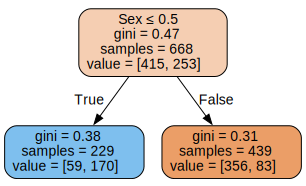

In [18]:
#For reference create a OneR model

#Create a OneR model
clf = DecisionTreeClassifier(criterion='gini', max_depth=1)
#Train the model
clf.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = clf.predict(X_valid)
# Model Accuracy, how often is the classifier correct?
print("MAE:",mean_absolute_error(y_valid, y_pred))
print("Accuracy:",metrics.accuracy_score(y_valid, y_pred))

draw_tree(clf, X_train, size=10)

MAE: 0.2242152466367713
Accuracy: 0.7757847533632287


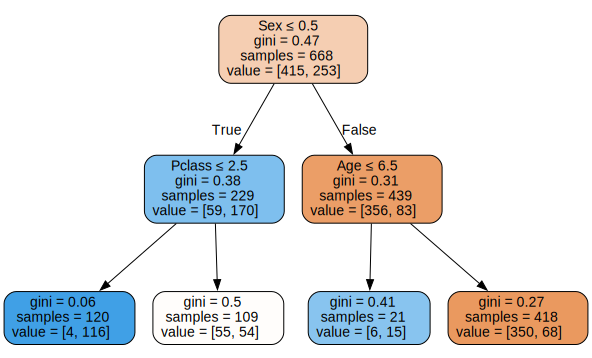

In [17]:
#Compare with a 2 level tree
clr_2 = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)

y_pred = clr_2.predict(X_valid)
print("MAE:",mean_absolute_error(y_valid, y_pred))
print("Accuracy:",metrics.accuracy_score(y_valid, y_pred))

draw_tree(clr_2, X_train, size=10)

In [19]:
#Slight improvement on MAE, but no improvement at accuracy with an additional level, although difficult to really conclude much on such a small validation set.
#Trying with a tree defined by the min amount of samples pr. leaf

MAE: 0.18385650224215247
Accuracy: 0.8161434977578476


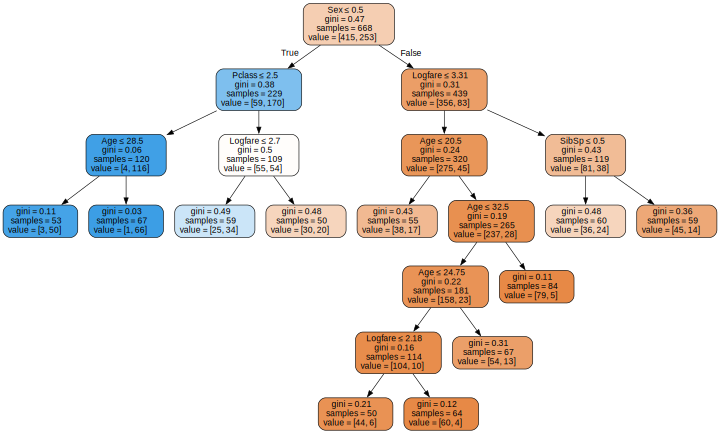

In [20]:
#Compare with a 2 level tree
clr_min_50 = DecisionTreeClassifier(min_samples_leaf=50).fit(X_train, y_train)

y_pred = clr_min_50.predict(X_valid)
print("MAE:",mean_absolute_error(y_valid, y_pred))
print("Accuracy:",metrics.accuracy_score(y_valid, y_pred))

draw_tree(clr_min_50, X_train, size=10)

## Random forests

Training a single model on a training set is suspect to random errors. By using bagging (bootstrap aggregating) we can train multiple models on different subsets of the training data, and then average their predictions, thereby reducing the variance of the predictions. **That's the idea behind random forests.** 

https://link.springer.com/article/10.1007/BF00058655 

The idea is that we want each model's predictions in the averaged ensemble to be uncorrelated with each other model. That way, if we average the predictions, the average will be equal to the true target value -- that's because the average of lots of uncorrelated random errors is zero. That's quite an amazing insight!

One way we can create a bunch of uncorrelated models is to train each of them on a different random subset of the data. Here's how we can create a tree on a random subset of the data:

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(X_train, y_train);
mean_absolute_error(y_valid, rf.predict(X_valid))

0.18834080717488788

Similar performance to that of the previous decision tree.

### Feature importance
A nice function of random forrests is the ability to easily tell what independent variables are most important in the model:

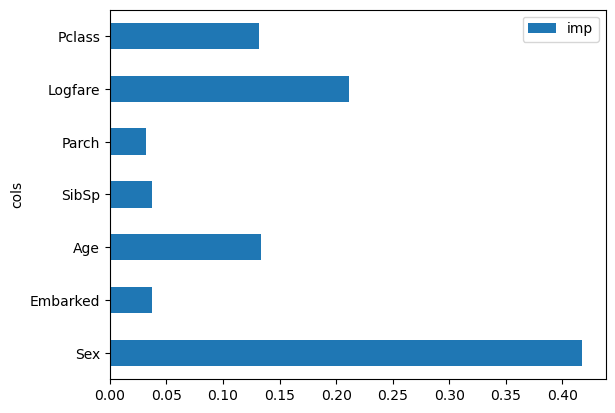

In [23]:
pd.DataFrame({'cols':X_train.columns, 'imp':rf.feature_importances_}).plot('cols','imp','barh');

### Order only matters, not the actual numbers
**Note** We didn't really need to take the log() of Fare, since random forests only care about order, and log() doesn't change the order -- we only did it to make our graphs earlier easier to read.

Explain boosting in the context of decision trees in a few lines: Boosting 